In [1]:
import numpy as np
from matplotlib import pyplot as plt
import math
from math import exp, sqrt, pi
import time

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset,RandomSampler

In [2]:
epochs = 50
device = torch.device("cpu")

eps = 0.1

learning_rate = 1e-3
batchflag = True
batchsize = 128

start = 0.
end = 1.
x = np.linspace(start,end,100 )
y = np.linspace(start,end,100)
x, y = np.meshgrid(x, y)
x = np.reshape(x, (np.size(x[:]),1))
y = np.reshape(y, (np.size(y[:]),1))

def actual_soln(eps):
    sinpix = np.array([[math.sin(math.pi*ind[0])] for ind in x])
    sinpiy = np.array([[math.sin(math.pi*ind[0])] for ind in y])
    return ((sinpix)**2) * ((sinpiy)**2)
#f = 8*(eps**2)*((math.pi)**4)*(cos2pix*cos2piy - cos2pix*sinpiy*sinpiy - cos2piy*sinpix*sinpix) - 2*((math.pi)**2)*(cos2pix*sinpiy*sinpiy + cos2piy*sinpix*sinpix)

In [3]:
def plot_graph(soln,soln_name):
    x = np.linspace(start,end,100);y = np.linspace(start,end,100)
    x,y = np.meshgrid(x,y)
    ax = plt.axes(projection='3d')
    ax.plot_surface(x,y,soln.reshape(100,100))
    plt.title(soln_name)
    plt.show()

def plot_graphs(soln1,soln2,soln_name):
    x = np.linspace(start,end,100);y = np.linspace(start,end,100)
    x,y = np.meshgrid(x,y)
    ax = plt.axes(projection='3d')
    ax.plot_surface(x,y,soln1.reshape(100,100))
    plt.title(soln_name)
    plt.show()

class Swish(nn.Module):
	def __init__(self, inplace=True):
		super(Swish, self).__init__()
		self.inplace = inplace

	def forward(self, x):
		if self.inplace:
			x.mul_(torch.sigmoid(x))
			return x
		else:
			return x * torch.sigmoid(x)
	

class FBPINN(nn.Module):
	hid_dim = 128
	input_dim = 2 
	def __init__(self):
		super(FBPINN, self).__init__()
		self.tanh = nn.Tanh()
		self.lin0 = nn.Linear(self.input_dim,self.hid_dim)
		self.lin = nn.Linear(self.hid_dim,self.hid_dim)
		self.lin1 = nn.Linear(self.hid_dim,1)
		self.swish = Swish()


	def forward(self,x):		
		tanh1 = self.tanh(x)
		tanh2 = self.tanh(1 - x)
		tanh11 = (tanh1[:,0].unsqueeze(1))*(tanh1[:,1].unsqueeze(1))*(tanh1[:,0].unsqueeze(1))*(tanh1[:,1].unsqueeze(1))
		tanh22 = (tanh2[:,0].unsqueeze(1))*(tanh2[:,1].unsqueeze(1))*(tanh2[:,0].unsqueeze(1))*(tanh2[:,1].unsqueeze(1))
		x = self.lin0(x)
		x = self.swish(x)
		x = self.lin(x)
		x = self.swish(x)
		x = self.lin(x)
		x = self.swish(x)
		x = self.lin(x)
		x = self.swish(x)
		x = self.lin1(x)
		out = x*tanh11*tanh22
		return out

In [4]:

def train(device,net,x,y,eps,learning_rate,epochs,batch_flag,batch_size):

	xnet = torch.Tensor(x)
	ynet = torch.Tensor(y) 
	
	if(batch_flag):
		dataset = TensorDataset(xnet,ynet)
		dataloader = DataLoader(dataset, batch_size=batch_size,shuffle=True,num_workers = 0,drop_last = True )
		print(len(dataloader))
	
	optimizer = optim.Adam(net.parameters(), lr=learning_rate, betas = (0.9,0.99),eps = 10**-15)

	def Loss_criterion(xnet,ynet):
		xnet.requires_grad = True
		ynet.requires_grad = True
		points = torch.cat((xnet,ynet),1) 
		U = net(points)
		U = U.view(len(U),-1)
		
		soln = (torch.sin(np.pi*xnet))**2 * (torch.sin(np.pi*ynet))**2
		
		soln_x = torch.autograd.grad(soln,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		soln_xx = torch.autograd.grad(soln_x,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		soln_xxx = torch.autograd.grad(soln_xx,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		soln_xxxx = torch.autograd.grad(soln_xxx,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		soln_y = torch.autograd.grad(soln,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		soln_yy = torch.autograd.grad(soln_y,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		soln_yyy = torch.autograd.grad(soln_yy,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		soln_yyyy = torch.autograd.grad(soln_yyy,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		soln_xxy = torch.autograd.grad(soln_xx,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		soln_xxyy = torch.autograd.grad(soln_xxy,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		
		f = (eps**2)*(soln_xxxx + soln_yyyy + 2*soln_xxyy) - (soln_xx + soln_yy)
		
		U_x = torch.autograd.grad(U,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		U_xx = torch.autograd.grad(U_x,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		U_xxx = torch.autograd.grad(U_xx,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		U_xxxx = torch.autograd.grad(U_xxx,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		U_y = torch.autograd.grad(U,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		U_yy = torch.autograd.grad(U_y,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		U_yyy = torch.autograd.grad(U_yy,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		U_yyyy = torch.autograd.grad(U_yyy,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		U_xxy = torch.autograd.grad(U_xx,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		U_xxyy = torch.autograd.grad(U_xxy,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		loss1 = (eps**2)*(U_xxxx + U_yyyy + 2*U_xxyy) - (U_xx + U_yy) - f 
		
		return nn.MSELoss()(loss1,torch.zeros_like(loss1)) 

	losses = []
	tic = time.time()

	if(batch_flag):
		for epoch in range(epochs):
			if epoch == 30:
				learning_rate = 0.00001
				new_optimizer = optim.Adam(net.parameters(), lr=learning_rate, betas = (0.9,0.99),eps = 10**-15)
				optimizer = new_optimizer
			for batch_idx, (x_in,y_in) in enumerate(dataloader):

				net.zero_grad()
				loss = Loss_criterion(x_in,y_in)
				loss.backward()

				optimizer.step() 
				if batch_idx % 20 ==0:
					print('Train Epoch: {} \tLoss: {:.20f}'.format(epoch, loss.item()))

			points = torch.cat((xnet,ynet),1)
			U = net(points)
			z = U.detach().numpy()
			actual_loss = np.square(actual_soln(eps) - z).mean()
			print('\nAfter Epoch {}, \t Actual solution loss: {:.20f}\n'.format(
				epoch, actual_loss))
			if epoch % 1 == 0:
				plot_graph(z,'Predicted solution')
			
			losses.append([loss.item(),actual_loss])

	else:
		for epoch in range(epochs):
			if epoch == 50:
				learning_rate = 0.00001
				new_optimizer = optim.Adam(net.parameters(), lr=learning_rate, betas = (0.9,0.99),eps = 10**-15)
				optimizer = new_optimizer
		
			net.zero_grad()
			loss = Loss_criterion(xnet,ynet)
			loss.backward()
			
			optimizer.step() 
			points = torch.cat((xnet,ynet),1)
			U = net(points)
			z = U.detach().numpy()
			actual_loss = np.square(actual_soln(eps) - z).mean()
			print('\nAfter Epoch {}, \t Actual solution loss: {:.20f}\n'.format(
				epoch, actual_loss))
			if epoch % 5 == 0:
				plot_graph(z,'Predicted solution')
			
			losses.append([loss.item(),actual_loss])

	toc = time.time()
	elapseTime = toc - tic
	print ("Time elapsed = ", elapseTime)

	net_in = torch.cat((xnet,ynet),1)
	output = net(net_in)  
	
	return output,net 

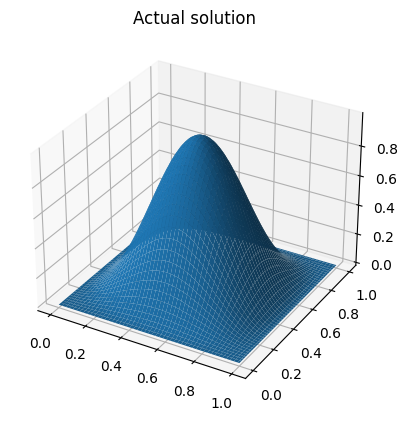

In [7]:
plot_graph(actual_soln(0.0001),'Actual solution')



1


78
Train Epoch: 0 	Loss: 687187.37500000000000000000
Train Epoch: 0 	Loss: 939886.68750000000000000000
Train Epoch: 0 	Loss: 624796.56250000000000000000
Train Epoch: 0 	Loss: 211938.15625000000000000000

After Epoch 0, 	 Actual solution loss: 0.0022469499



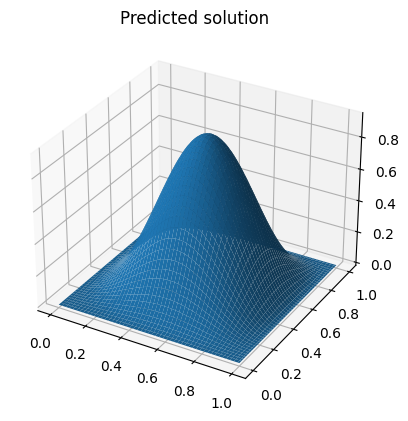

Train Epoch: 1 	Loss: 84056.86718750000000000000
Train Epoch: 1 	Loss: 19510.04492187500000000000
Train Epoch: 1 	Loss: 5842.73486328125000000000
Train Epoch: 1 	Loss: 1454.94580078125000000000

After Epoch 1, 	 Actual solution loss: 0.0000044319



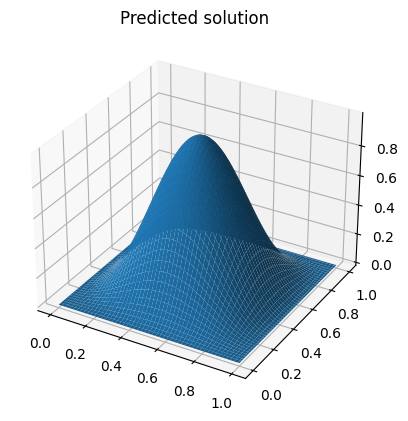

Train Epoch: 2 	Loss: 794.04821777343750000000
Train Epoch: 2 	Loss: 492.88549804687500000000


In [9]:
net = FBPINN()#.to(device)
	
def init_normal(m):
	if type(m) == nn.Linear:
		nn.init.kaiming_normal_(m.weight)

net.apply(init_normal)

for eps in [1,0.1,0.01,0.001,0.0001,0.00001]:
	print('\n\n{}\n\n'.format(eps))
	output,net = train(device,net,x,y,eps,learning_rate,epochs,batchflag,batchsize)
	plot_graph(output.detach().numpy(),"After one round")